In [ ]:
!pip install faiss-cpu pandas pyarrow huggingface_hub

In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="abhijit26/movie-vector-galaxy",
    repo_type="dataset",
    local_dir="data_full",
    local_dir_use_symlinks=False
)

In [ ]:
import os
import pandas as pd
import numpy as np
import faiss

In [ ]:
DATA_DIR = "data_full"

os.listdir(DATA_DIR)

## Metadata - Movie Information

In [ ]:
meta = pd.read_parquet(f"{DATA_DIR}/metadata.parquet")

In [ ]:
print(f"meta shape {meta.shape}")
meta.columns.tolist()

In [ ]:
meta.head(3)

In [ ]:
meta.info(memory_usage="deep")

In [ ]:
meta.isnull().sum().sort_values(ascending=False).head(18)

In [ ]:
meta.describe(include="all")

## Embeddings - Stores Semantic meanning

In [ ]:
emb = np.load(f"{DATA_DIR}/embeddings.npy")

In [ ]:
emb.shape

In [ ]:
emb.dtype

In [ ]:
emb.nbytes / (1024**3)

In [ ]:
emb[0][:10]

In [ ]:
np.linalg.norm(emb[0])

## FAISS index - fast search
This file is built FROM embeddings.
faiss.swigfaiss_avx2.IndexFlatIP type of faiss

In [ ]:
index = faiss.read_index(f"{DATA_DIR}/faiss_index.faiss")

In [ ]:
type(index)

In [ ]:
index.ntotal

In [ ]:
index.d

In [ ]:
movie_idx = 100

D, I = index.search(emb[movie_idx].reshape(1, -1), 5)

meta.iloc[I[0]][["title"]]

## development dataset creation

In [ ]:
DATA_FULL = "data_full"
DATA_DEV = "data_dev"

os.makedirs(DATA_DEV, exist_ok=True)

meta = pd.read_parquet(f"{DATA_FULL}/metadata.parquet")
emb = np.load(f"{DATA_FULL}/embeddings.npy").astype("float32")

In [ ]:
meta["imdb_votes"] = meta["imdb_votes"].fillna(0)
meta["imdb_votes"].describe()

In [ ]:
DEV_SIZE = 20000

top_meta = (
    meta.sort_values("imdb_votes", ascending=False)
        .head(DEV_SIZE)
)

In [ ]:
# to keep embedding align
indices = top_meta.index.to_numpy()
indices.sort()

In [ ]:
meta_dev = meta.iloc[indices].reset_index(drop=True)

meta_dev.to_parquet(f"{DATA_DEV}/metadata.parquet")

meta_dev.shape

In [ ]:
emb_dev = emb[indices]

np.save(f"{DATA_DEV}/embeddings.npy", emb_dev)

emb_dev.shape

In [ ]:
dim = emb_dev.shape[1]

index_dev = faiss.IndexFlatIP(dim)
index_dev.add(emb_dev)

faiss.write_index(index_dev, f"{DATA_DEV}/faiss_index.faiss")

In [ ]:
print(len(meta_dev))
print(emb_dev.shape[0])
print(index_dev.ntotal)

In [ ]:
movie_idx = 100

D, I = index_dev.search(
    emb_dev[movie_idx].reshape(1, -1),
    5
)

meta_dev.iloc[I[0]][["title", "imdb_votes"]]

In [ ]:
import shutil
import os

output_filename = "data_dev"
zip_directory = "data_dev"

if os.path.exists(zip_directory):
    shutil.make_archive(output_filename, 'zip', zip_directory)
    print(f"Successfully created {output_filename}.zip")
else:
    print(f"Directory '{zip_directory}' not found. Please ensure it exists before zipping.")

In [ ]:
import shutil; import os; output_filename = "data_dev"; zip_directory = "data_dev"; shutil.make_archive(output_filename, 'zip', zip_directory) if os.path.exists(zip_directory) else print(f"Directory '{zip_directory}' not found. Please ensure it exists before zipping.")

In [ ]:
DATA_DEV = "data_dev"

meta = pd.read_parquet(f"{DATA_DEV}/metadata.parquet")
emb = np.load(f"{DATA_DEV}/embeddings.npy")
index = faiss.read_index(f"{DATA_DEV}/faiss_index.faiss")

print("Loaded:", len(meta))

In [ ]:
title_to_idx = {
    title.lower(): idx
    for idx, title in enumerate(meta["title"])
}

def recommend_similar(movie_title, k=5):

    movie_title = movie_title.lower()

    if movie_title not in title_to_idx:
        print("Movie not found!")
        return

    idx = title_to_idx[movie_title]

    query_vec = emb[idx].reshape(1, -1)

    # +1 because first result is the movie itself
    D, I = index.search(query_vec, k + 1)

    results = meta.iloc[I[0][1:]][[
        "title",
        "year",
        "imdb_votes"
    ]]

    return results.reset_index(drop=True)

recommend_similar("tenet")

## UMAP Creation

In [1]:
import numpy as np
import pandas as pd
import umap

In [2]:
DATA_DEV = "data_dev"

emb = np.load(f"{DATA_DEV}/embeddings.npy")

print(emb.shape)

(20000, 768)


In [3]:
from sklearn.preprocessing import normalize

emb_norm = normalize(emb, norm="l2")

In [4]:
reducer = umap.UMAP(
    n_components=3,      # 3D galaxy
    n_neighbors=30,      # cluster structure
    min_dist=0.05,       # tighter clusters
    metric="cosine",     # matches embeddings
    random_state=42,
    verbose=True
)

In [5]:
coords = reducer.fit_transform(emb_norm)

/home/abhijit/projects/movie-vector-galaxy/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_components=3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Sun Feb 22 10:27:18 2026 Construct fuzzy simplicial set
Sun Feb 22 10:27:19 2026 Finding Nearest Neighbors
Sun Feb 22 10:27:19 2026 Building RP forest with 12 trees
Sun Feb 22 10:27:23 2026 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Sun Feb 22 10:27:38 2026 Finished Nearest Neighbor Search
Sun Feb 22 10:27:39 2026 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Feb 22 10:27:50 2026 Finished embedding


In [6]:
coords.shape

(20000, 3)

In [7]:
galaxy_df = pd.DataFrame({
    "vector_id": meta["vector_id"],
    "x": coords[:, 0],
    "y": coords[:, 1],
    "z": coords[:, 2],
})

In [8]:
for col in ["x", "y", "z"]:
    galaxy_df[col] = (
        galaxy_df[col] - galaxy_df[col].mean()
    ) / galaxy_df[col].std()

In [9]:
galaxy_df.to_parquet(
    f"{DATA_DEV}/galaxy_coords.parquet",
    index=False
)

print("Galaxy coordinates saved ✅")

Galaxy coordinates saved ✅


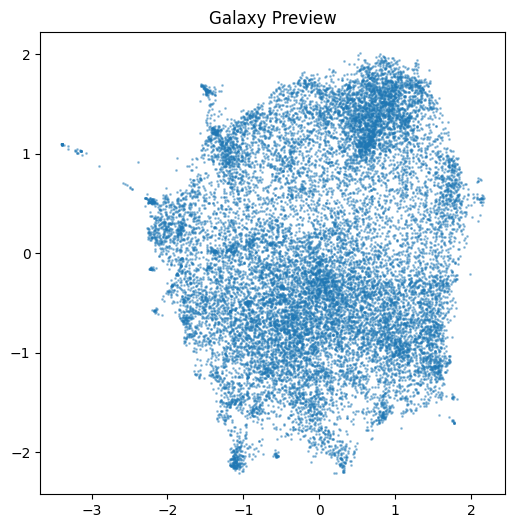

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(
    galaxy_df["x"],
    galaxy_df["y"],
    s=1,
    alpha=0.4
)
plt.title("Galaxy Preview")
plt.show()